fatal: destination path 'Celebrity-Face-Recognition' already exists and is not an empty directory.
Dataset baixado e bibliotecas importadas!
Iniciando extração de faces (isso pode levar 1-2 minutos)...
Processando: virat_kohli...
Processando: roger_federer...
Processando: serena_williams...
Processando: maria_sharapova...
Processando: lionel_messi...
Faces extraídas com sucesso!
Found 271 images belonging to 5 classes.
Found 66 images belonging to 5 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Treinando para reconhecer 5 pessoas: ['lionel_messi', 'maria_sharapova', 'roger_federer', 'serena_williams', 'virat_kohli']


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.2444 - loss: 2.0610 - val_accuracy: 0.4697 - val_loss: 1.1736
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5375 - loss: 1.2190 - val_accuracy: 0.6061 - val_loss: 0.9880
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6370 - loss: 0.9396 - val_accuracy: 0.6970 - val_loss: 0.8488
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7520 - loss: 0.7891 - val_accuracy: 0.7879 - val_loss: 0.7925
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7700 - loss: 0.6476 - val_accuracy: 0.7424 - val_loss: 0.7331
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7686 - loss: 0.5969 - val_accuracy: 0.7424 - val_loss: 0.6721
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8172 - loss: 0.5845 - val_accuracy: 0.8030 - val_loss: 0.6563
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8830 - loss: 0.4048 - val_accuracy: 0.7273 - val_loss: 0.6729
Epoch 9/

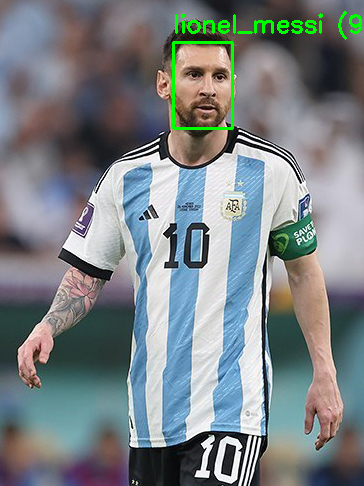

In [2]:
# =============================================================================
# ETAPA 1: PREPARAÇÃO DO AMBIENTE E DOWNLOAD DO DATASET
# =============================================================================
# Instala as bibliotecas necessárias
!pip install mtcnn tensorflow opencv-python-headless matplotlib

# Clona o repositório do GitHub que contém as fotos dos famosos
# Fonte: https://github.com/mikeffendii/Celebrity-Face-Recognition
!git clone https://github.com/mikeffendii/Celebrity-Face-Recognition.git

import os
import cv2
import numpy as np
import tensorflow as tf
from mtcnn import MTCNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

print("Dataset baixado e bibliotecas importadas!")

# =============================================================================
# ETAPA 2: PRÉ-PROCESSAMENTO (EXTRAIR ROSTOS DAS FOTOS BAIXADAS)
# =============================================================================
# O dataset original tem fotos de corpo inteiro. Vamos recortar só os rostos.

def create_face_dataset(raw_dir, processed_dir='processed_dataset'):
    detector = MTCNN()

    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)

    # Percorre as pastas baixadas do GitHub
    for person_name in os.listdir(raw_dir):
        person_path = os.path.join(raw_dir, person_name)

        # Ignora arquivos que não sejam pastas
        if not os.path.isdir(person_path): continue

        # Cria a pasta de destino para a pessoa
        save_path = os.path.join(processed_dir, person_name)
        if not os.path.exists(save_path): os.makedirs(save_path)

        print(f"Processando: {person_name}...")

        for img_name in os.listdir(person_path):
            img_path = os.path.join(person_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None: continue
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Detecta onde está o rosto na foto
                results = detector.detect_faces(img_rgb)

                if results:
                    # Pega o rosto com maior confiança
                    x, y, w, h = results[0]['box']
                    x, y = max(0, x), max(0, y)

                    # Recorta apenas o rosto
                    face = img_rgb[y:y+h, x:x+w]
                    face = cv2.resize(face, (224, 224)) # Redimensiona para o padrão da rede

                    # Salva na nova pasta
                    face_bgr = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(os.path.join(save_path, img_name), face_bgr)
            except Exception as e:
                pass # Ignora erros de leitura

# Caminho onde o git clone salvou as imagens originais
raw_dataset_path = 'Celebrity-Face-Recognition/Images Dataset'

print("Iniciando extração de faces (isso pode levar 1-2 minutos)...")
create_face_dataset(raw_dataset_path)
print("Faces extraídas com sucesso!")

# =============================================================================
# ETAPA 3: TREINAMENTO DA REDE NEURAL (TRANSFER LEARNING)
# =============================================================================

def train_model(data_dir='processed_dataset'):
    # Aumenta os dados artificialmente (Data Augmentation) para melhorar o treino
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    # Base: MobileNetV2 (leve e rápida)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False # Congela o conhecimento prévio

    # Cabeça: Nossas camadas de classificação
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(f"Treinando para reconhecer {train_generator.num_classes} pessoas: {list(train_generator.class_indices.keys())}")

    # Treina por 10 épocas
    model.fit(train_generator, epochs=10, validation_data=validation_generator)

    return model, train_generator.class_indices

# Executa o treinamento
model, class_indices = train_model()
labels = {v: k for k, v in class_indices.items()} # Dicionário invertido (0: 'Messi', etc)

# =============================================================================
# ETAPA 4: TESTE FINAL (BAIXANDO UMA FOTO DA INTERNET PARA TESTAR)
# =============================================================================

def recognize_faces_from_url(image_url, model, labels):
    # Baixa uma imagem da internet para testar
    os.system(f"wget -O test_image.jpg {image_url}")

    detector = MTCNN()
    img = cv2.imread("test_image.jpg")

    if img is None:
        print("Erro ao baixar imagem de teste.")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(img_rgb)

    print(f"Faces detectadas: {len(results)}")

    for res in results:
        x, y, w, h = res['box']

        # Recorta e prepara para a rede
        face = img_rgb[y:y+h, x:x+w]
        try:
            face_resized = cv2.resize(face, (224, 224))
        except: continue # Pula se o recorte for inválido

        face_normalized = face_resized / 255.0
        face_batch = np.expand_dims(face_normalized, axis=0)

        # Predição
        prediction = model.predict(face_batch)
        class_id = np.argmax(prediction)
        confidence = np.max(prediction)

        name = labels.get(class_id, "Desconhecido")

        # Desenha o resultado
        color = (0, 255, 0) if confidence > 0.7 else (0, 0, 255) # Verde se tiver certeza, Vermelho se não
        label_text = f"{name} ({confidence:.1%})"

        cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
        cv2.putText(img, label_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    cv2_imshow(img)

# --- TESTE AO VIVO ---
# Vamos testar com uma foto do Lionel Messi (que está no dataset)
print("\n--- TESTANDO COM FOTO DO LIONEL MESSI ---")
test_url = "https://upload.wikimedia.org/wikipedia/commons/b/b4/Lionel-Messi-Argentina-2022-FIFA-World-Cup_%28cropped%29.jpg"
recognize_faces_from_url(test_url, model, labels)